In [24]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.special import erf
from astropy.table import Table, vstack


# Everything above should import with no issue, everything below needs directing
homepath = "/global/homes/c/cpopik/"
packpath = homepath+"Packages/"

import camb
sys.path.append(packpath + "hmvec/")
import hmvec as hm
from hmvec.params import default_params, battaglia_defaults

In [2]:
# Get data

resultspath="/global/homes/c/cpopik/Results/"
ls_data = np.load(resultspath+"ls_NW.npy")
Cl_gy_data = np.load(resultspath+"LRGs_y_Cls_NW.npy")
Cl_gg_data = np.load(resultspath+"LRGs_LRGs_Cls_NW.npy")
Cl_yy_data = np.load(resultspath+"y_y_Cls_NW.npy")

Cl_gysims = np.load(resultspath+"Cl_g_ysims.npy")
Cl_randomsy = np.load(resultspath+"Cl_randoms_y.npy")
Cl_ysimsysims = np.load(resultspath+"Cl_ysims_ysims.npy")
Cl_randomsrandoms = np.load(resultspath+"Cl_randoms_randoms.npy")

Cl_gy_err = np.std(Cl_gysims, axis=0)
Cl_gg_err = np.std(Cl_randomsrandoms, axis=0)

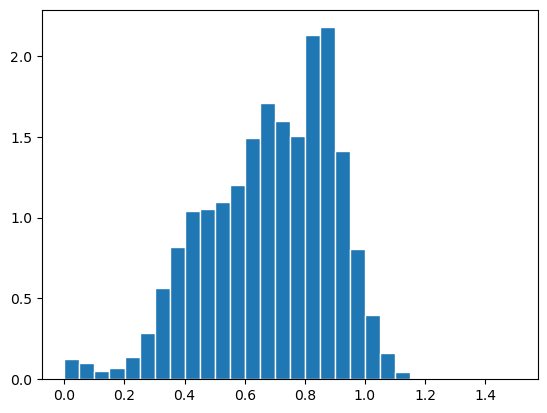

In [3]:
# Get z distribution for the Cls calculation

table = Table.read(homepath + '/DESI_Data/DESI_LRGs_ACTD56.csv')
targetdata = table.to_pandas()

# Sets RA limits to match ACT maps
targetdata['RA'].where(targetdata['RA'] < 180, targetdata['RA'] - 360, inplace=True)

data_zs = targetdata['Z_PHOT_MEAN'].values
area = (max(targetdata.RA)-min(targetdata.RA))*(max(targetdata.DEC)-min(targetdata.DEC))

gdndz, zbins = plt.hist(data_zs, bins=np.linspace(1e-4, 1.5, 31), ec='w', weights=np.ones(len(data_zs))/area, density=True)[0:2]
gzs = zbins[:-1]+((zbins[1]-zbins[0])/2)

In [4]:
# Make the halo model

zs = np.linspace(0, 1.5, 5)  # changes MCMC time
ms = np.geomspace(10**11.75, 10**15, 50)  # Changes MCMC time
ks = np.geomspace(1e-4, 100, 1001)
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20
nxs = 500  # changes MCMC Time

In [5]:
# Add the HOD and pressure profiles

def Nc_LRG(logM, params):
    f_ic, logM_cut, sigma = [params.get(key) for key in ['f_ic', 'logM_cut', 'sigma']]
    return (f_ic / 2) * (1- erf((logM_cut - logM)/(np.sqrt(2)*sigma)))

def Ns_LRG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - kappa * M_cut) / M_1)**alpha * Nc

LRG_paper_params = {
    'logM_cut': 12.7*np.ones(hcos.ms.size),
    'logM_1': 13.6*np.ones(hcos.ms.size),
    'sigma': 0.2,
    'alpha': 1.15,
    'kappa': 0.08,
    'f_ic': 0.8
}


mthresh=10**10.5+zs*0.

hcos.add_custom_hod(name="LRG_HOD",mthresh=mthresh, ignore_existing=True, 
                    Nc_model=Nc_LRG, Ns_model=Ns_LRG, 
                    model_params=LRG_paper_params, z_dep=False)

hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

/global/homes/c/cpopik/Packages/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [26]:
battaglia_defaults['pres']

{'P0_A0': 18.1,
 'P0_alpham': 0.154,
 'P0_alphaz': -0.758,
 'xc_A0': 0.497,
 'xc_alpham': -0.00865,
 'xc_alphaz': 0.731,
 'beta_A0': 4.35,
 'beta_alpham': 0.0393,
 'beta_alphaz': 0.415}

In [31]:
def ClModel2(P0_A0, xc_A0, beta_A0):
    battparams = {'P0_A0': P0_A0, 'xc_A0': xc_A0, 'beta_A0': beta_A0}
    hcos.add_battaglia_pres_profile("ywalk",family='pres', param_override=battparams, xmax=xmax,nxs=nxs, ignore_existing=True)
    Pyy_walk = hcos.get_power('ywalk', verbose=False);
    C_yy_walk = hcos.C_yy_new(ls_data, zs, ks, Pyy_walk, gzs=gzs)
    return C_yy_walk

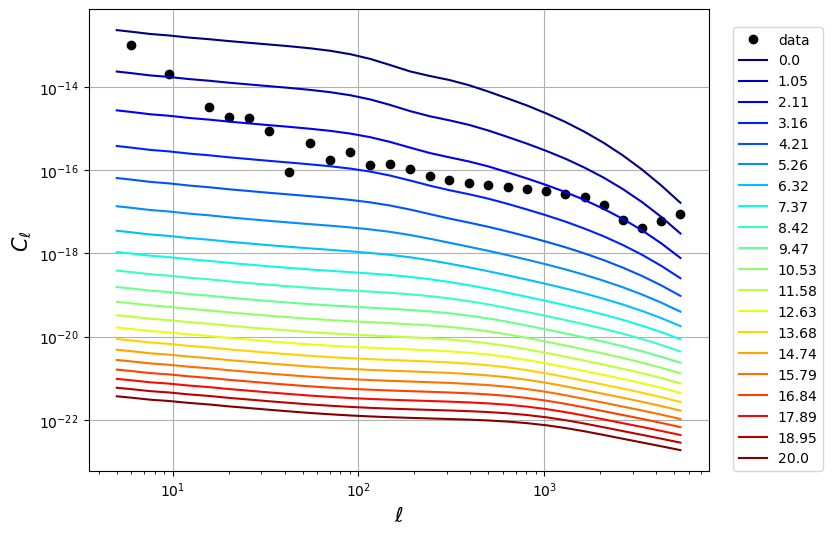

In [48]:
plt.figure(figsize=(8, 6)), plt.grid(), plt.loglog()
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$C_\ell$', fontsize=15)

plt.plot(ls_data, Cl_yy_data, ls='', marker='o', label='data', color='k')

params = np.linspace(0, 20, 20)
colors = plt.cm.jet(np.linspace(0,1,len(params)))
for i in range(len(params)):
    cltest = ClModel2(18.1, 0.497, params[i])
    plt.plot(ls_data, cltest, label=str(np.round(params[i], 2)), color=colors[i])

plt.legend(fontsize=10, loc=(1.04, 0))
plt.show()